# Algoritmos Metaheurísticos: Examen 2
Profesor: Dr. Marco Aceves <br>
Alumno: Ing. Enrique Mena Camilo

In [1]:
import pandas as pd
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")


## EDA

In [2]:
data = pd.read_excel(
    "data/DMN Report 29.xlsx",
    sheet_name=[0, 1, 2, 3, 4, 5],
    header=None, skiprows=5, usecols=[0, 1, 2],
    names=["WEEK", "LACTOSE", "WHEY"]
)
data.keys()


dict_keys([0, 1, 2, 3, 4, 5])

### Unión de datos en un único dataframe

In [3]:
def month_to_q(month: str):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4
    else:
        return None


In [4]:
clen_data = []
year = 2023
for idx in range(len(data)):
    year_data = data[idx].copy()
    # Elimina las filas "AVG"
    year_data = year_data[~year_data["WEEK"].astype(str).str.contains("AVG")]
    # Estandarizamos el formato de la columna "WEEK"
    year_data["WEEK"] = year_data["WEEK"].astype(str).transform(lambda x: (x.replace(" ", "").split("-")[0]))
    # Elimninamos las filas nan
    year_data = year_data.dropna()
    # Agregamos el año
    year_data["YEAR"] = year
    # Agregamos el mes
    year_data["MONTH"] = year_data["WEEK"].transform(lambda x: parse(x).month)
    # Agregamos el trimestre
    year_data["QUARTER"] = year_data["MONTH"].transform(month_to_q)# Agregamos al arreglo
    # Agrupamos el año-quarter
    year_data["YEAR_QUARTER"] = year_data['YEAR'].astype(str) + "-Q" + year_data['QUARTER'].astype(str)
    # Agregamos al arreglo
    clen_data.append(year_data.copy())
    # Disminuimos el año
    year -= 1
    del year_data

# Concatenamos los datos
clean_data = pd.concat(clen_data).reset_index(drop=True)

clean_data.sample(10)


,WEEK,LACTOSE,WHEY,YEAR,MONTH,QUARTER,YEAR_QUARTER
247,10/14/19,0.2800,0.3300,2019,10,4,2019-Q4
90,1/11/21,0.4050,0.4850,2021,1,1,2021-Q1
185,11/2/20,0.4875,0.3850,2020,11,4,2020-Q4
197,1/27,0.5950,0.5800,2019,1,1,2019-Q1
138,12/13/21,0.4050,0.6625,2021,12,4,2021-Q4
34,8/28/23,0.2250,0.2700,2023,8,3,2023-Q3
269,3/10,0.5950,0.6150,2018,3,1,2018-Q1
184,10/26/20,0.4975,0.3650,2020,10,4,2020-Q4
115,7/5/21,0.4600,0.5675,2021,7,3,2021-Q3
83,11/28/22,0.4850,0.4350,2022,11,4,2022-Q4


### Estadistica descriptiva global

In [5]:
clean_data[['LACTOSE', 'WHEY']].describe().T


,count,mean,std,min,25%,50%,75%,max
LACTOSE,326.0,0.387347,0.103796,0.1925,0.305,0.4050,0.455000,0.635
WHEY,326.0,0.440479,0.132571,0.2350,0.350,0.4225,0.556875,0.805


### Graficos de distribución por año

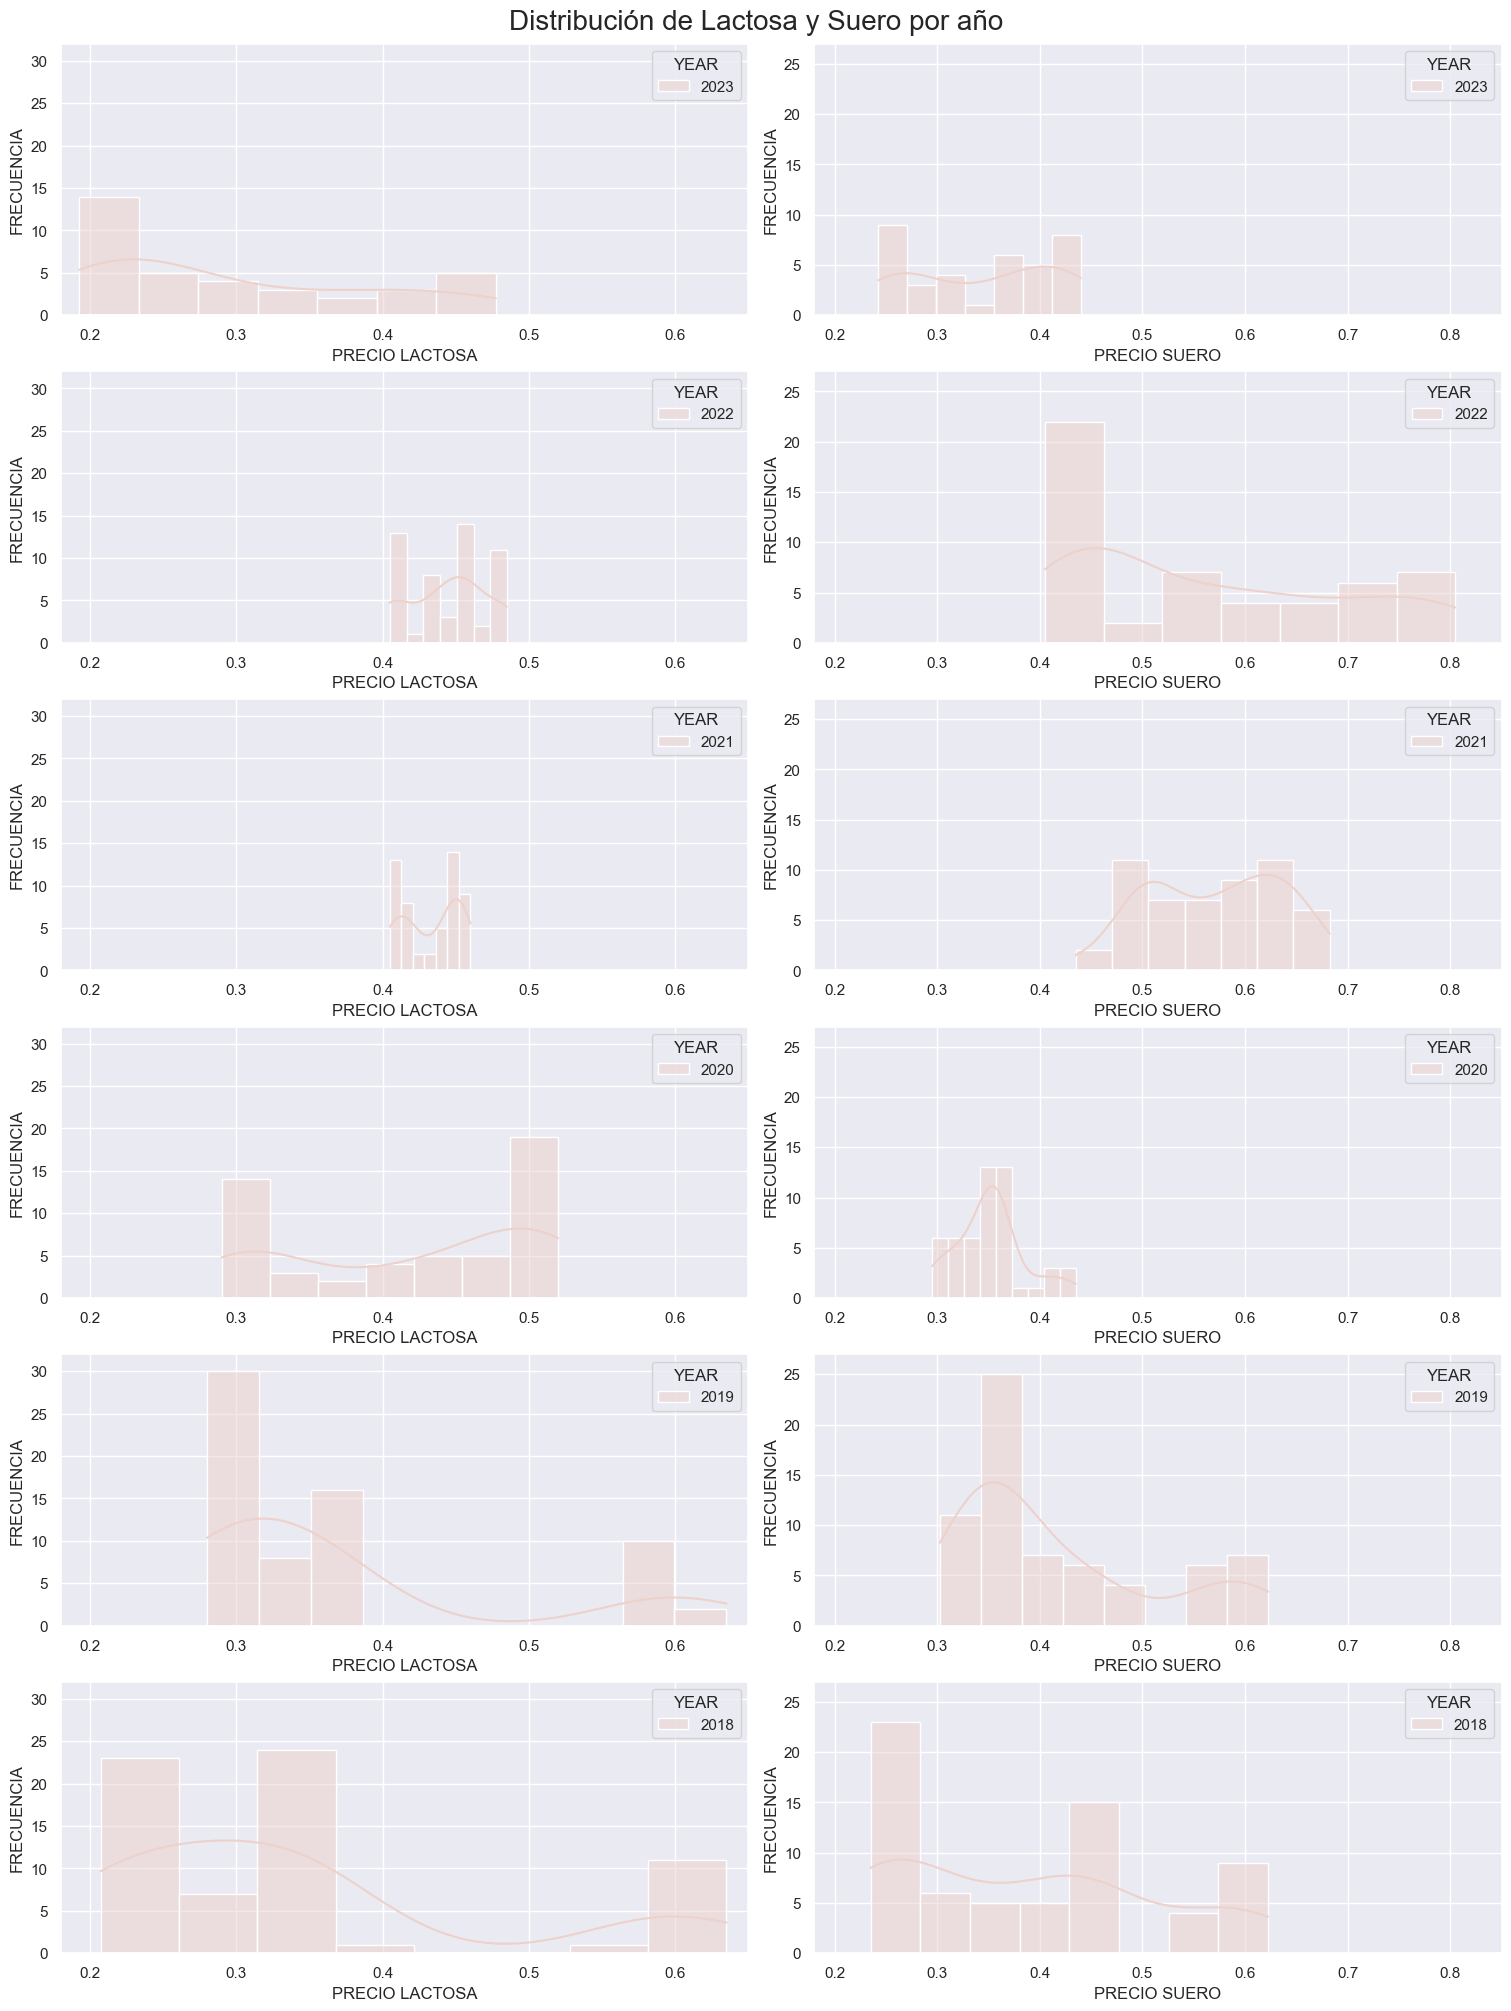

In [6]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20), layout="constrained")
fig.suptitle("Distribución de Lactosa y Suero por año", fontsize=20)

for idx, ax in enumerate(axes):
    year_data = clean_data[clean_data["YEAR"] == 2023-idx]
   
    sns.histplot(data=year_data, x="LACTOSE", hue="YEAR", kde=True, ax=ax[0])
    sns.histplot(data=year_data, x="WHEY", hue="YEAR", kde=True, ax=ax[1])
    
    ax[0].set_ylim(0, 32), ax[0].set_xlim(0.18, 0.65)
    ax[0].set_ylabel("FRECUENCIA"), ax[0].set_xlabel("PRECIO LACTOSA")
    
    ax[1].set_ylim(0, 27), ax[1].set_xlim(0.18, 0.85)
    ax[1].set_ylabel("FRECUENCIA"), ax[1].set_xlabel("PRECIO SUERO")
    

plt.savefig(f"figures/distribuciones_precio.png", bbox_inches='tight', dpi=300)


### Variación del precio sobre el tiempo

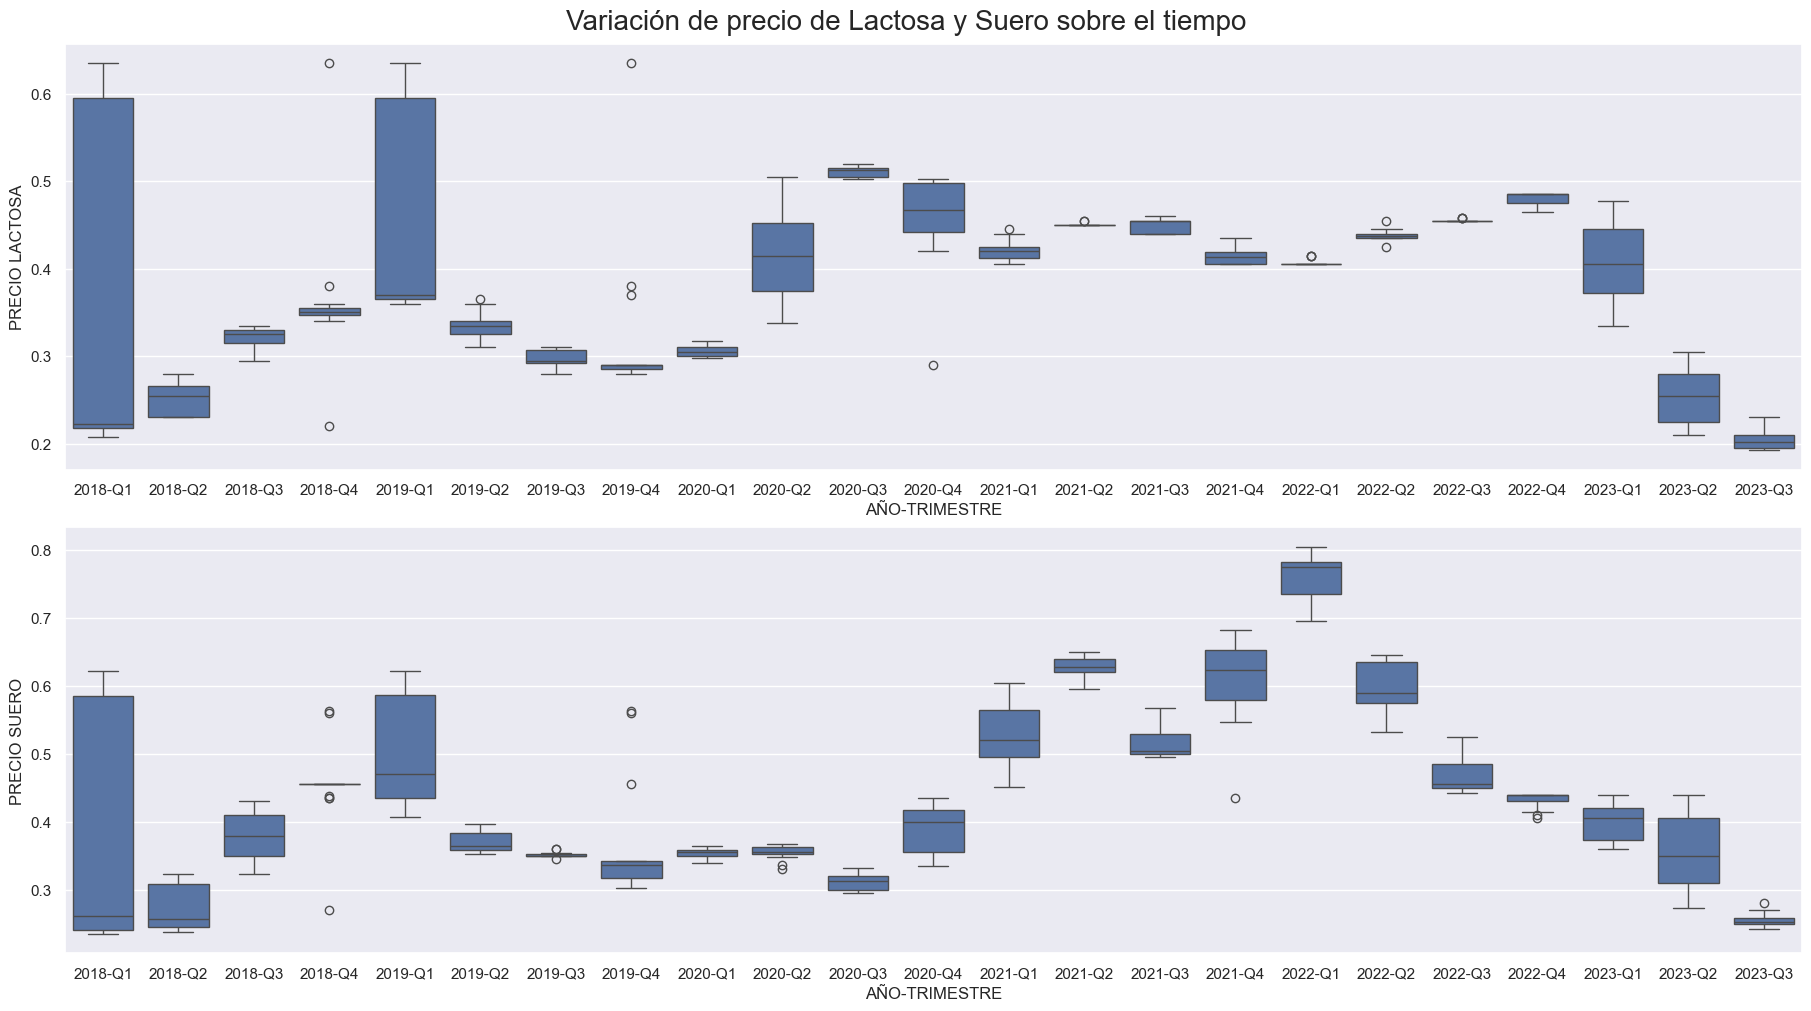

In [7]:
order = sorted(clean_data["YEAR_QUARTER"].unique())

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), layout="constrained")
fig.suptitle("Variación de precio de Lactosa y Suero sobre el tiempo", fontsize=20)

sns.boxplot(x="YEAR_QUARTER", y="LACTOSE", data=clean_data, order=order, ax=axes[0])
sns.boxplot(x="YEAR_QUARTER", y="WHEY", data=clean_data, order=order, ax=axes[1])

axes[0].set_ylabel("PRECIO LACTOSA"), axes[0].set_xlabel("AÑO-TRIMESTRE")
axes[1].set_ylabel("PRECIO SUERO"), axes[1].set_xlabel("AÑO-TRIMESTRE")

plt.savefig(f"figures/precio_tiempo.png", bbox_inches='tight', dpi=300)
